# Methodology: Monte Carlo Simulation of Cash Waqf-Linked Sukuk (CWLS) for MBG

This section explains the modeling framework, assumptions, simulation design, and sustainability metrics used to evaluate the feasibility of a perpetual waqf fund in financing the MBG program.

## 1. Research Design

This study employs a stochastic financial simulation approach using Monte Carlo methods to evaluate the sustainability of a perpetual waqf fund. The analysis is conducted over a 10-year horizon with 10,000 simulation paths. Each simulation generates random investment returns and food inflation rates, which determine the evolution of MBG costs and waqf fund performance. The primary objective is to estimate the probability that the waqf fund
can sustainably finance a target percentage of MBG total cost.

## 2. Model Framework

### 2.1 Investment Return Process

Annual investment returns follow a normal distribution:

r_t ~ N(μ_r, σ_r)

Where:
μ_r = expected return  
σ_r = return volatility  

### 2.2 Food Inflation Process

Food inflation follows:

π_t ~ N(μ_π, σ_π)

Inflation is truncated at a minimum positive level.

### 2.3 MBG Cost Function

Total MBG cost in year t:

C_t = N_t × c × d × Π(1 + π_i)

Where:
N_t = number of recipients  
c = cost per meal  
d = school days per year  
π_i = inflation rate  

### 2.4 Waqf Fund Dynamics

Let W_t denote fund value:

W_{t+1} = W_t + r_t W_t − Spending_t

Spending is defined as:

Spending_t = min(r_t W_t, α C_t)

Where: α = target coverage rate.

## 3. Sustainability Metrics

Two sustainability definitions are used:

1. Yearly Sustainability Probability:

P(r_t W_t ≥ α C_t)

This measures the probability that the fund can cover the target share in a given year.

2. Full-Horizon Sustainability Probability:

P(r_t W_t ≥ α C_t for all t = 1,...,T)

This measures the probability that the fund remains sustainable for the entire 10-year horizon.

The second metric is stricter and reflects long-term viability.

## 4. Parameter Assumptions

The model uses the following baseline assumptions:

- Expected return: 6.4%
- Return volatility: 0.5%
- Food inflation: 4–5%
- Cost per meal: Rp 15,000
- School days: 261 per year
- Recipients: Growth from 20M to 82.9M (Year 5) and Year 6 until Year 10 => 82.9M students for each year

In [21]:
# =========================
# PARAMETERS
# =========================
years <- 10
n_sim <- 10000

mean_yield <- 0.064
sd_yield <- 0.005

mean_infl  <- 0.045
sd_infl <- 0.005

cost_per_meal <- 15000
days_per_year <- 261 #weekdays only

target_coverage <- 0.20

# Recipients growth (20M -> 82.9M by year 5, constant after)
recipients <- numeric(years)
recipients[1] <- 20e6

for (t in 2:years) {
  if (t <= 5) {
    recipients[t] <- recipients[t - 1] + (82.9e6 - 20e6) / 4
  } else {
    recipients[t] <- 82.9e6
  }
}

## 5. Simulation Procedure

For each Monte Carlo iteration:

1. Draw random return and inflation paths.
2. Compute cumulative inflation.
3. Calculate MBG cost for each year.
4. Compute waqf yield income.
5. Determine coverage ratio.
6. Update fund value dynamically.
7. Record sustainability outcomes.

This process is repeated 10,000 times.

In [22]:
# =========================
# SIMULATION FUNCTION
# =========================
set.seed(123)

run_waqf_simulation <- function(principal, coverage_target = target_coverage) {

  coverage_matrix <- matrix(0, n_sim, years)

  for (sim in 1:n_sim) {
    
    yield     <- rnorm(years, mean_yield, sd_yield)
    inflation <- pmax(rnorm(years, mean_infl, sd_infl), 0.01)
      
    inflation_factor <- 1
    fund <- principal
    for (t in 1:years) {
        inflation_factor <- inflation_factor * (1 + inflation[t])
        mbg_cost_t <- recipients[t] * cost_per_meal * days_per_year * inflation_factor
        
        yield_income_t <- fund * yield[t]
        coverage_fraction <- yield_income_t / mbg_cost_t
        coverage_matrix[sim, t] <- coverage_fraction
        
        fund <- fund + yield_income_t - coverage_fraction * mbg_cost_t
    }
  }

  success <- coverage_matrix >= coverage_target

  prob_by_year   <- colMeans(success)
  prob_sustained <- mean(apply(success, 1, all))
  avg_coverage   <- colMeans(coverage_matrix)

  list(
    prob_by_year   = prob_by_year,
    prob_sustained = prob_sustained,
    avg_coverage   = avg_coverage,
    coverage_matrix = coverage_matrix
  )
}

## 6. Scenario Analysis

Two principal scenarios are evaluated:

- Rp 200 trillion
- Rp 400 trillion

These represent moderate and large-scale waqf fund formations. The objective is to compare sustainability probabilities across fund sizes.

In [23]:
# =========================
# RUN ALL SCENARIOS
# =========================
scenarios <- list(
  #"50T"  = 50e12,
  "200T" = 200e12,
  "400T" = 400e12
)

cat("================================================================\n")
cat("  MONTE CARLO: Dana Abadi Wakaf untuk MBG\n")
cat("================================================================\n")
cat(sprintf("  N = %s simulations | %d years | Yield ~ N(%.1f%%, %.1f%%)\n",
            format(n_sim, big.mark = ","), years,
            mean_yield * 100, sd_yield * 100))
cat(sprintf("  Inflasi ~ N(%.1f%%, %.1f%%) | Cost/ per meal Rp %s | %d days/yr\n",
            mean_infl * 100, sd_infl * 100,
            format(cost_per_meal, big.mark = ","), days_per_year))
cat(sprintf("  Target coverage: %.0f%% of MBG budget\n", target_coverage * 100))
cat("================================================================\n\n")

for (nm in names(scenarios)) {
  res <- run_waqf_simulation(scenarios[[nm]])

  cat(sprintf("--- Skenario %s (Principal Rp %s) ---\n", nm, nm))
  cat(sprintf("  P(sustained all %d years) = %.1f%%\n",
              years, res$prob_sustained * 100))
  cat("  Per-year:\n")
  for (t in 1:years) {
    cat(sprintf("    Year %2d: P(>=%.0f%%) = %5.1f%%  |  Avg coverage = %.2f%%\n",
                t, target_coverage * 100,
                res$prob_by_year[t] * 100,
                res$avg_coverage[t] * 100))
  }
  cat("\n")
}

  MONTE CARLO: Dana Abadi Wakaf untuk MBG
  N = 10,000 simulations | 10 years | Yield ~ N(6.4%, 0.5%)
  Inflasi ~ N(4.5%, 0.5%) | Cost/ per meal Rp 15,000 | 261 days/yr
  Target coverage: 20% of MBG budget

--- Skenario 200T (Principal Rp 200T) ---
  P(sustained all 10 years) = 0.0%
  Per-year:
    Year  1: P(>=20%) =   0.0%  |  Avg coverage = 15.64%
    Year  2: P(>=20%) =   0.0%  |  Avg coverage = 8.39%
    Year  3: P(>=20%) =   0.0%  |  Avg coverage = 5.57%
    Year  4: P(>=20%) =   0.0%  |  Avg coverage = 4.09%
    Year  5: P(>=20%) =   0.0%  |  Avg coverage = 3.16%
    Year  6: P(>=20%) =   0.0%  |  Avg coverage = 3.03%
    Year  7: P(>=20%) =   0.0%  |  Avg coverage = 2.90%
    Year  8: P(>=20%) =   0.0%  |  Avg coverage = 2.77%
    Year  9: P(>=20%) =   0.0%  |  Avg coverage = 2.65%
    Year 10: P(>=20%) =   0.0%  |  Avg coverage = 2.54%

--- Skenario 400T (Principal Rp 400T) ---
  P(sustained all 10 years) = 0.0%
  Per-year:
    Year  1: P(>=20%) = 100.0%  |  Avg coverage = 31.

## 7. Coverage Optimization (Sweet Spot Analysis)

To determine the maximum feasible coverage level, a grid search approach is used. Coverage targets ranging from 0.5% to 20% are tested. For each level, the full-horizon sustainability probability is calculated. The “sweet spot” is defined as the highest coverage rate that achieves at least:

- 90% sustainability probability
- 80% sustainability probability
- 50% sustainability probability

In [24]:
cat("\n================================================================\n")
cat("================================================================\n")
cat("  SWEET SPOT COVERAGE: MBG FUND SUSTAINABILITY\n")
cat("================================================================\n")

# Coverage fractions to test (0.5% → 20% of total MBG cost)
sweep_targets <- seq(0.005, 0.20, by = 0.001)  # finer grid

# Loop over scenarios
for (nm in names(scenarios)) {
  
  principal <- scenarios[[nm]]
  
  # Run simulation to get coverage_matrix (dynamic fund included if updated)
  res <- run_waqf_simulation(principal)
  cov_mat <- res$coverage_matrix
  
  # Function to calculate full-horizon sustainability probability for a given coverage fraction
  calc_full_prob <- function(coverage_frac) {
    mean(apply(cov_mat >= coverage_frac, 1, all))  # probability all 10 years ≥ coverage_frac
  }
  
  # Compute probability for each sweep target
  probs <- vapply(sweep_targets, calc_full_prob, numeric(1))
  
  # Function to find the coverage fraction corresponding to a given sustainability probability
  find_coverage_for_prob <- function(prob_thresh) {
    hits <- which(probs >= prob_thresh)
    if(length(hits) == 0) return(NA_real_)
    sweep_targets[max(hits)]  # largest coverage fraction that meets the threshold
  }
  
  # Find “sweet spot” coverage for different probability thresholds
  coverage_90 <- find_coverage_for_prob(0.90)
  coverage_80 <- find_coverage_for_prob(0.80)
  coverage_50 <- find_coverage_for_prob(0.50)
  
  cat("\n  Scenario", nm, " (Principal =", principal, ")\n")
  cat("    Coverage for 90% sustainability probability :", if(is.na(coverage_90)) "N/A" else paste0(round(coverage_90*100,3), "%"), "\n")
  cat("    Coverage for 80% sustainability probability :", if(is.na(coverage_80)) "N/A" else paste0(round(coverage_80*100,3), "%"), "\n")
  cat("    Coverage for 50% sustainability probability :", if(is.na(coverage_50)) "N/A" else paste0(round(coverage_50*100,3), "%"), "\n")
}

cat("\n================================================================\n")


  SWEET SPOT COVERAGE: MBG FUND SUSTAINABILITY

  Scenario 200T  (Principal = 2e+14 )
    Coverage for 90% sustainability probability : 2.2% 
    Coverage for 80% sustainability probability : 2.3% 
    Coverage for 50% sustainability probability : 2.4% 

  Scenario 400T  (Principal = 4e+14 )
    Coverage for 90% sustainability probability : 4.4% 
    Coverage for 80% sustainability probability : 4.6% 
    Coverage for 50% sustainability probability : 4.9% 



## 8. Model Assumptions and Limitations

This model is developed under the following key assumptions:

- Investment returns (yield) and food inflation follow normal distributions, characterized by constant means and standard deviations over time.

- The waqf fund evolves dynamically according to a financial accumulation mechanism, where the fund balance in each year is updated based on realized returns and actual spending.

- Spending from the fund is constrained by the available yield, consistent with a perpetual (principal-preserving) waqf structure.

Given these assumptions, the simulation results should be interpreted as baseline probabilistic estimates under normal economic conditions rather than precise forecasts. Extreme market shocks, structural breaks, policy changes, or governance frictions are not explicitly modeled.

## Visualization

In [25]:
set.seed(123)

library(ggplot2)
library(dplyr)
library(tidyr)
library(patchwork)
library(scales)

# =========================
# RUN SIMULATIONS
# =========================
scenarios <- list("200T" = 200e12, "400T" = 400e12)
COLORS   <- c("200T" = "#2196F3", "400T" = "#4CAF50")

results <- lapply(scenarios, function(p) run_waqf_simulation(p))

# =========================================================================
# PLOT 1 — Coverage Trajectory Fan Chart (median + 50% & 90% CI)
# =========================================================================
fan_data <- do.call(rbind, lapply(names(scenarios), function(nm) {
  cm <- results[[nm]]$coverage_matrix
  data.frame(
    scenario = nm,
    year     = 1:years,
    median   = apply(cm, 2, median),
    p05      = apply(cm, 2, quantile, 0.05),
    p25      = apply(cm, 2, quantile, 0.25),
    p75      = apply(cm, 2, quantile, 0.75),
    p95      = apply(cm, 2, quantile, 0.95)
  )
}))

p1 <- ggplot(fan_data, aes(x = year)) +
  geom_ribbon(aes(ymin = p05, ymax = p95, fill = scenario), alpha = 0.15) +
  geom_ribbon(aes(ymin = p25, ymax = p75, fill = scenario), alpha = 0.30) +
  geom_line(aes(y = median, color = scenario), linewidth = 1) +
  geom_hline(yintercept = target_coverage, linetype = "dashed",
             color = "red", linewidth = 0.7) +
  annotate("text", x = 1, y = target_coverage + 0.008,
           label = paste0("Target ", target_coverage * 100, "%"),
           hjust = 0, color = "red", size = 3.5, fontface = "bold") +
  scale_x_continuous(breaks = 1:10) +
  scale_y_continuous(labels = percent_format(accuracy = 1)) +
  scale_fill_manual(values = COLORS) +
  scale_color_manual(values = COLORS) +
  labs(title = "Coverage Trajectory (Median + 50% & 90% CI)",
       x = "Year", y = "Coverage of MBG Budget",
       fill = "Scenario", color = "Scenario") +
  theme_minimal(base_size = 12) +
  theme(legend.position = "bottom",
        plot.title = element_text(face = "bold", size = 11)) + coord_cartesian(clip = "off")

# =========================================================================
# PLOT 2 — Year-by-Year Sustainability Probability
# =========================================================================
prob_data <- do.call(rbind, lapply(names(scenarios), function(nm) {
  data.frame(
    scenario = nm,
    year     = 1:years,
    prob     = results[[nm]]$prob_by_year
  )
}))

p2 <- ggplot(prob_data, aes(x = factor(year), y = prob, fill = scenario)) +
  geom_col(position = position_dodge(width = 0.7), width = 0.6) +
  geom_text(aes(label = sprintf("%.0f%%", prob * 100)),
            position = position_dodge(width = 0.7),
            vjust = -0.4, size = 2.8) +
  scale_y_continuous(labels = percent_format(), limits = c(0, 1.08),
                     expand = expansion(mult = c(0, 0))) +
  scale_fill_manual(values = COLORS) +
  labs(title = bquote(bold("P(Coverage" >= .(target_coverage * 100) * "%) by Year")),
       x = "Year", y = "Probability", fill = "Scenario") +
  theme_minimal(base_size = 12) +
  theme(legend.position = "bottom",
        plot.title = element_text(size = 11))

# =========================================================================
# PLOT 3 — Sweet Spot Curve: P(sustained 10yr) vs Coverage Target
# =========================================================================
sweep_targets <- seq(0.005, 0.20, by = 0.001)

sweep_data <- do.call(rbind, lapply(names(scenarios), function(nm) {
  cm <- results[[nm]]$coverage_matrix
  probs <- vapply(sweep_targets, function(tgt) {
    mean(apply(cm >= tgt, 1, all))
  }, numeric(1))
  data.frame(scenario = nm, coverage = sweep_targets, prob = probs)
}))

sweet_spots <- do.call(rbind, lapply(names(scenarios), function(nm) {
  sub <- sweep_data[sweep_data$scenario == nm, ]
  do.call(rbind, lapply(c(0.50, 0.80, 0.90), function(p) {
    hits <- which(sub$prob >= p)
    cov  <- if (length(hits) == 0) NA_real_ else sub$coverage[max(hits)]
    data.frame(scenario = nm, threshold = p, coverage = cov,
               label = paste0(p * 100, "%"))
  }))
}))
sweet_spots <- sweet_spots[!is.na(sweet_spots$coverage), ]

p3 <- ggplot(sweep_data, aes(x = coverage * 100, y = prob, color = scenario)) +
  geom_line(linewidth = 1) +
  geom_hline(yintercept = c(0.50, 0.80, 0.90),
             linetype = "dotted", color = "grey50", linewidth = 0.4) +
  geom_point(data = sweet_spots,
             aes(x = coverage * 100, y = threshold),
             size = 3, shape = 18) +
  annotate("text", x = 19, y = c(0.52, 0.82, 0.92),
           label = c("50%", "80%", "90%"),
           hjust = 1, size = 3, color = "grey40") +
  scale_x_continuous(breaks = seq(0, 20, 2)) +
  scale_y_continuous(labels = percent_format(), limits = c(0, 1)) +
  scale_color_manual(values = COLORS) +
  labs(title = "Sweet Spot: P(Sustained 10yr) vs Coverage Target",
       x = "Coverage Target (%)",
       y = "P(Sustained All 10 Years)",
       color = "Scenario") +
  theme_minimal(base_size = 12) +
  theme(legend.position = "bottom",
        plot.title = element_text(face = "bold", size = 11))

# =========================================================================
# PLOT 4 — Year-10 Coverage Distribution
# =========================================================================
dist_data <- do.call(rbind, lapply(names(scenarios), function(nm) {
  data.frame(
    scenario = nm,
    coverage = results[[nm]]$coverage_matrix[, years]
  )
}))

p4 <- ggplot(dist_data, aes(x = coverage, fill = scenario)) +
  geom_density(alpha = 0.4, color = NA) +
  geom_vline(xintercept = target_coverage, linetype = "dashed",
             color = "red", linewidth = 0.7) +
  annotate("text", x = target_coverage + 0.003, y = Inf,
           label = paste0("Target "),
           hjust = 0, vjust = 2, color = "red", size = 3.5, fontface = "bold") +
  scale_x_continuous(labels = percent_format(accuracy = 1)) +
  scale_fill_manual(values = COLORS) +
  labs(title = paste0("Year ", years, " Coverage Distribution"),
       x = "Coverage of MBG Budget", y = "Density",
       fill = "Scenario") +
  theme_minimal(base_size = 12) +
  theme(legend.position = "bottom",
        plot.title = element_text(face = "bold", size = 11)) + coord_cartesian(clip = "off")

# =========================================================================
# COMBINE & SAVE
# =========================================================================
combined <- (p1 + p2) / (p3 + p4) +
  plot_annotation(
    title    = "Monte Carlo Simulation: Dana Abadi Wakaf untuk MBG",
    subtitle = sprintf(
      "N = %s simulations | Yield ~ N(%.1f%%, %.1f%%) | Inflation ~ N(%.1f%%, %.1f%%) | %d days/yr",
      format(n_sim, big.mark = ","),
      mean_yield * 100, sd_yield * 100,
      mean_infl * 100, sd_infl * 100,
      days_per_year
    ),
    theme = theme(
      plot.title    = element_text(face = "bold", size = 14, hjust = 0.5),
      plot.subtitle = element_text(size = 10, color = "grey40", hjust = 0.5),
      plot.margin = margin(5.5, 20, 5.5, 5.5)
    )
  )

ggsave("fig_mc_combined.png", combined, width = 14, height = 10, dpi = 300)

ggsave("fig_mc_coverage_trajectory.png", p1, width = 8, height = 5, dpi = 300)
ggsave("fig_mc_yearly_probability.png",  p2, width = 8, height = 5, dpi = 300)
ggsave("fig_mc_sweet_spot.png",          p3, width = 8, height = 5, dpi = 300)
ggsave("fig_mc_terminal_distribution.png", p4, width = 8, height = 5, dpi = 300)

cat("All plots saved.\n")


All plots saved.


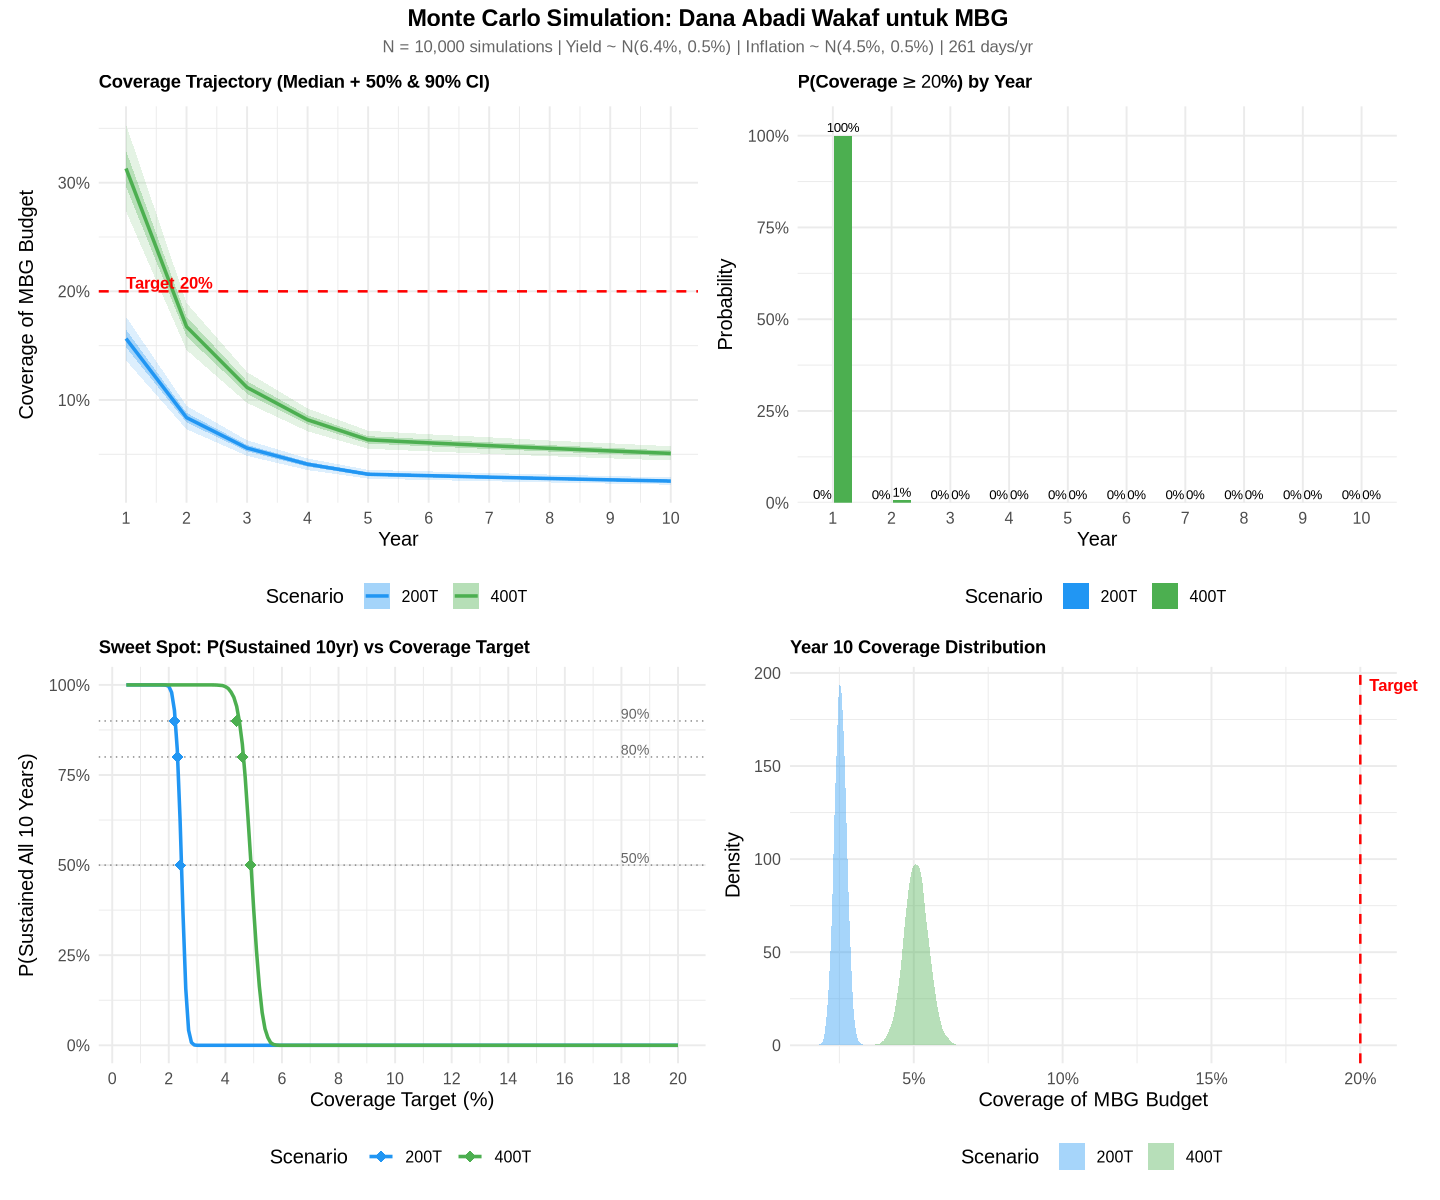

In [26]:
options(repr.plot.width = 12, repr.plot.height = 10)
print(combined)